# Gaussian_Filter_MHD

Analyzes how a CNN trained to differentiate MHD-only vs MHD+cosmic ray images
classifies MHD images that have been gaussian smoothed to varying extents.
This smoothing mocks the effects of cosmic rays, which act as a drag force on
fluctuations, effectively smoothing out sharp density features.

## Load packages and simulation data pre-split into training, validation, and test subsets

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset, random_split
import pdb
import os

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

!pip install cmasher
!pip install torchmetrics

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [21]:
# Configuration that was used for the model
# configuration for training
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    run_name = 'MHD_CRTransport_FullPwr_twoClasses_newData'
    sim_type = 'classify' # either classify or unet
    data_presplit = True # whether data has already been split into training, val, test
    #fileDirArr = ['MHD_beta10', 'CR_Advect_beta10', 'CR_Diff_Fiducial_beta10', 'CR_Diff100_beta10']
    fileDirArr = ['MHD_beta10', 'CR_Diff_Fiducial_beta10']
    field_list = ['density']
    killPwr = False
    num_classes = 2
    train_frac = 0.6
    batch_size = 64
    epochs = 20
    stop_early = True
    patience = 5
    run_locally = True # if running on my computer, take files from local directory instead of downloading them

config = TrainingConfig()

In [16]:
# structure of the saved model
model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.AdaptiveAvgPool2d(4), # works with any input size
    nn.Flatten(),
    nn.Linear(64*4*4,config.num_classes)
)

# path to checkpoint file
path_to_chk = 'Full_Power/models/with_split_data/'

# load the saved model checkpoint
model.load_state_dict(torch.load(path_to_chk + config.run_name + '_checkpoint.pt',map_location=torch.device('cpu')))
model.eval()

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU()
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): SiLU()
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): SiLU()
  (11): Dropout(p=0.25, inplace=False)
  (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): SiLU()
  (15): Dropout(p=0.25, inplace=False)
  (16): AdaptiveAvgPool2d(output_size=4)
  (17): Flatten(start_dim=1, end_dim=-1)
  (18): Linear(in_features=1024, out_features=2, bias=Tr

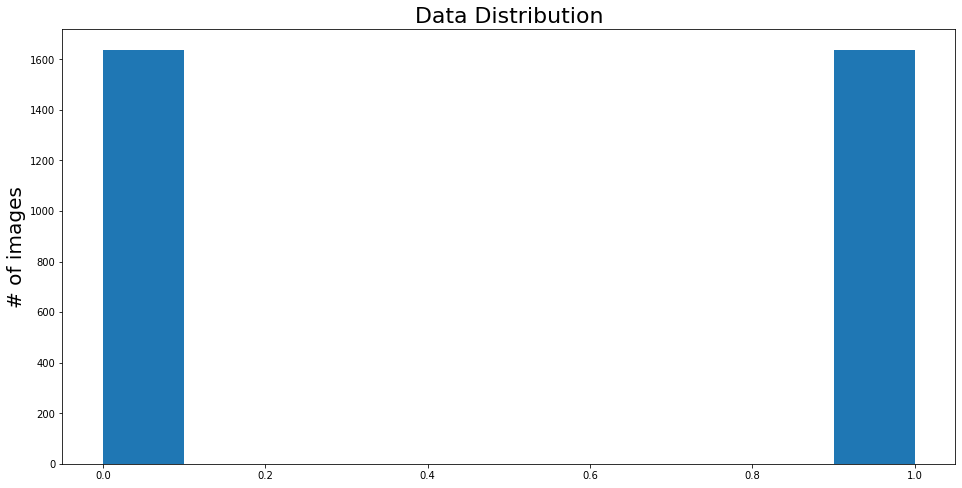

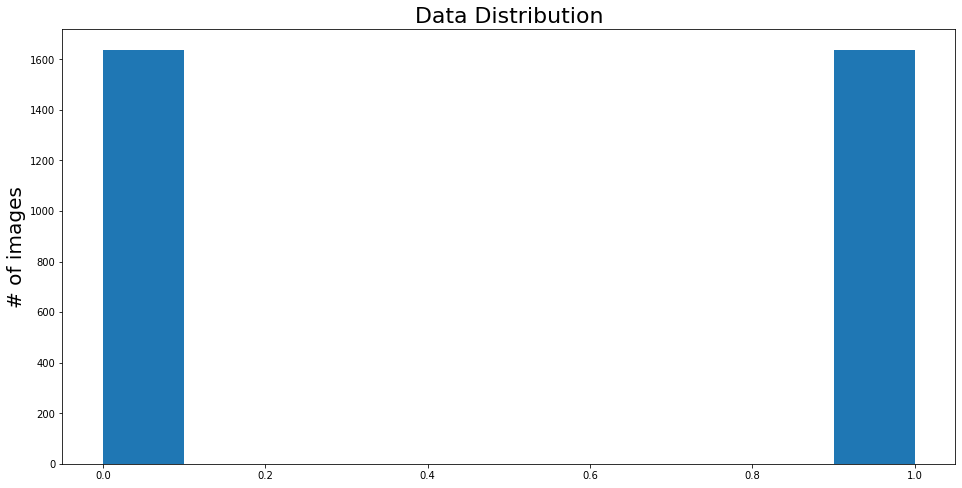

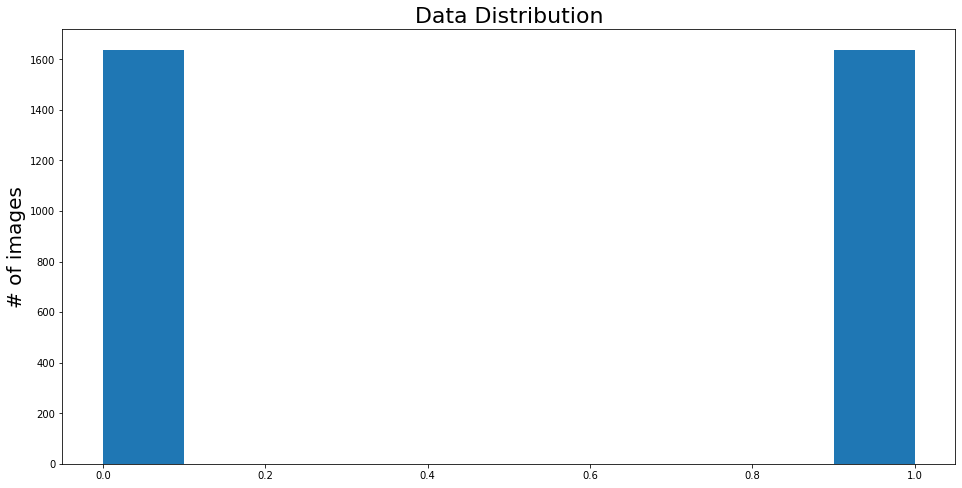

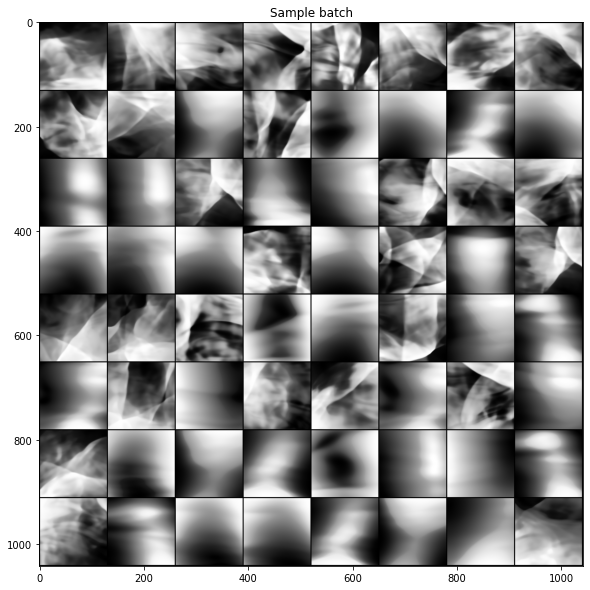

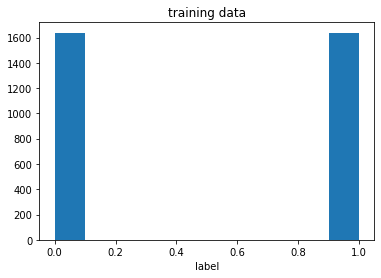

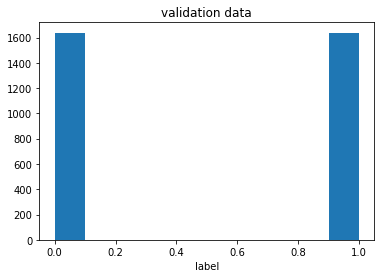

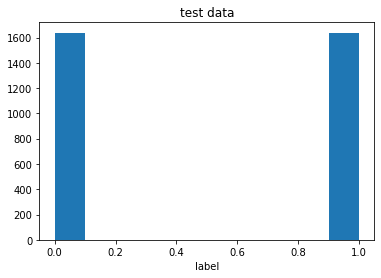

In [22]:
# If on Google Colab, need to clone repo to have access to helper files load_data and interpret_CNN

# ! git clone link/to/your/repo

from load_data import preprocess
from interpret_CNN import power1D

# load data
train_dl, valid_dl, test_dl = preprocess(config)

## Differentiating classes based on spectra

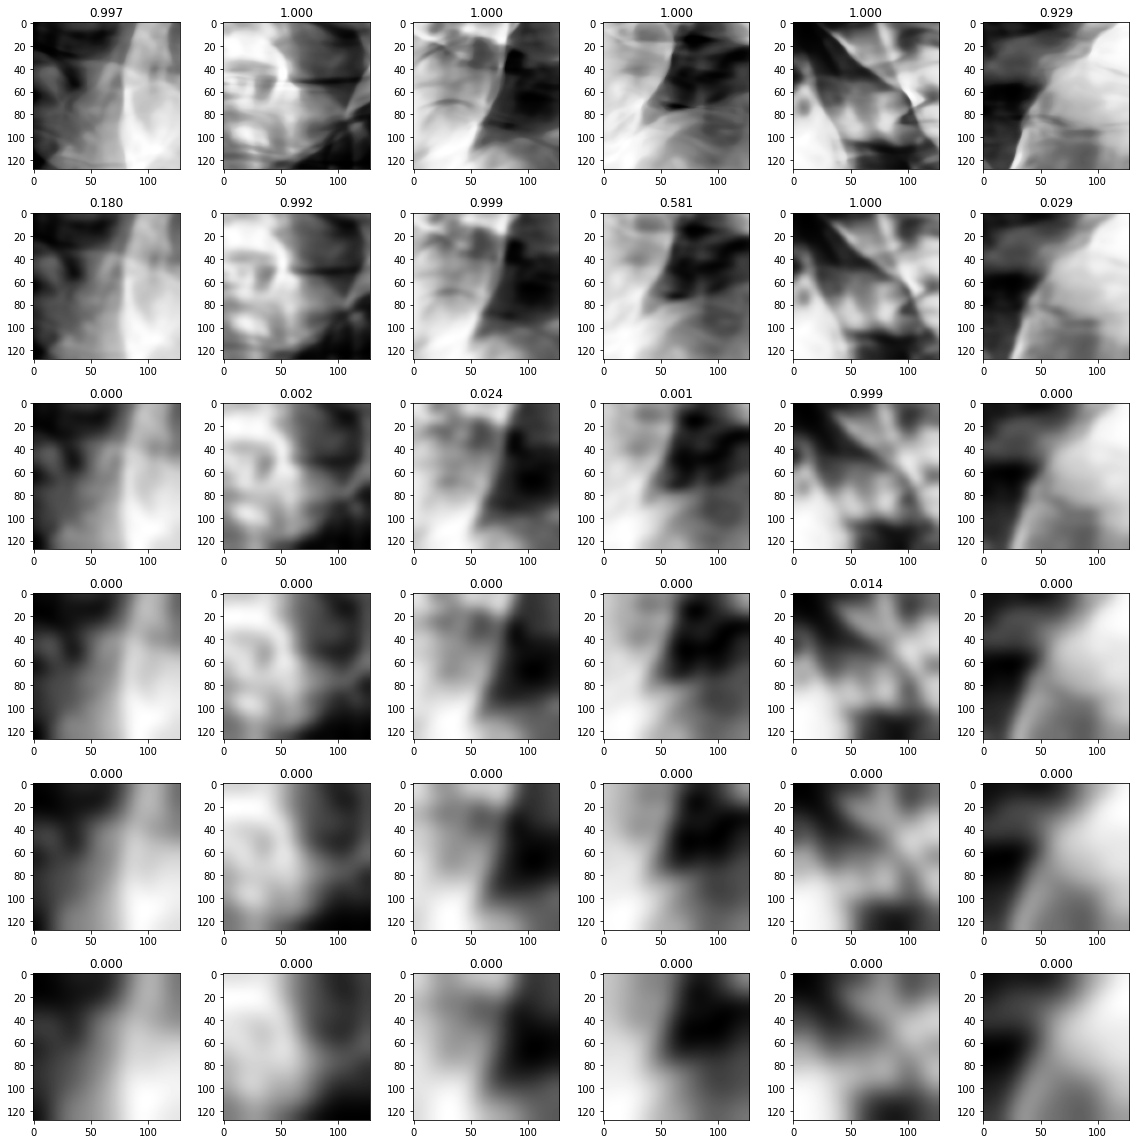

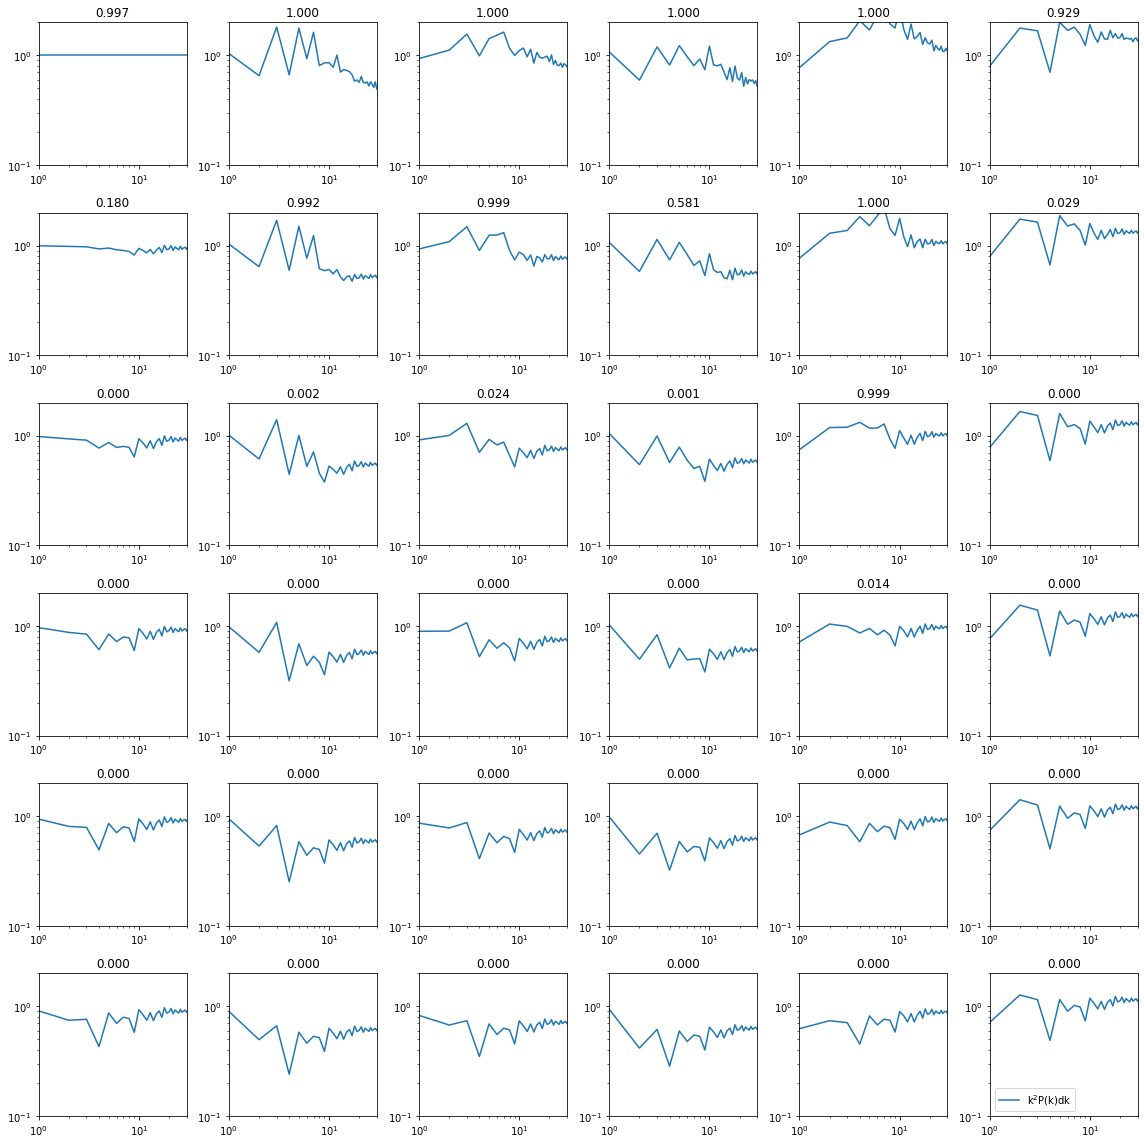

In [23]:
# Show gaussian filtered images belonging to class sim_class and their power spectra
# Image titles are probability that the image belongs to sim_class

from scipy.ndimage.filters import gaussian_filter
import seaborn as sns

# which class to show probability of
sim_class = 0

n_examples = 6 # number of columns
n_sigmas = 6 # number of different sigmas

fig, axs = plt.subplots(n_sigmas, n_examples, figsize=(16,16))
fig_spectra, axs_spectra = plt.subplots(n_sigmas, n_examples, figsize=(16,16)) 

# access a batch of labelled images
dataiter = iter(test_dl)
images, labels = next(dataiter)

# select n_example example images from each class
images_to_plot = images[labels==0]
k_norm, pwr_norm = power1D(images_to_plot[0,:,:,:])
for i in range(0,n_sigmas):
    for j in range(0,n_examples):
        plt_image = images_to_plot[j,:,:,:]

        # apply a Gaussian filter with standard deviation sigma to the image
        plt_image = torch.from_numpy(gaussian_filter(plt_image,sigma=float(2*i)))

        # create 1D power spectrum of filtered image
        k, pwr = power1D(plt_image)

        #run inference on modified image
        output = model(plt_image.reshape(1,1,plt_image.shape[-2],plt_image.shape[-1]))
        output = nn.functional.softmax(output, dim=1) # makes it a probability for each class

        prob = output.tolist()[0][int(sim_class)] # grab probability that it was classified as class sim_class

        axs[i,j].imshow(plt_image.squeeze(),cmap='gray')
        axs[i,j].set_title('{:.3f}'.format(prob))

        axs_spectra[i,j].loglog(k,pwr*(k**2)/(pwr_norm*(k_norm**2)),label=r"k$^{2}$P(k)dk")
        axs_spectra[i,j].set_title('{:.3f}'.format(prob))
        axs_spectra[i,j].set_xlim(1,30)
        axs_spectra[i,j].set_ylim(1.E-1,2.0)

cols = ['Example {}'.format(col) for col in range(1, n_examples+1)]
rows = config.fileDirArr



fig.tight_layout()
fig_spectra.tight_layout()
plt.legend()
plt.show() 


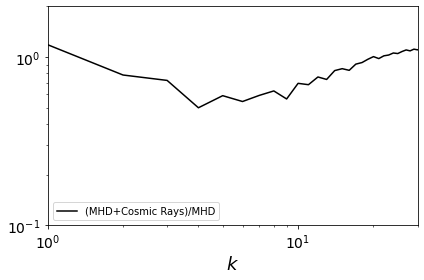

In [25]:
# Let's plot some average spectra for the two classes

# access a batch of labelled images
dataiter = iter(test_dl)
images, labels = next(dataiter)

# select n_example example images from each class
images_class0 = images[labels==0]
images_class1 = images[labels==1]

pwrvec0 = np.zeros(64)
pwrvec1 = np.zeros(64)

for i in range(0,len(images_class0)):
    plt_image = images_class0[i,:,:,:]

    # create 1D power spectrum of filtered image
    kvec, pwr = power1D(plt_image)

    pwrvec0 = np.vstack([pwrvec0, pwr]) # does the eigenmode analysis and spits out KE vs k


avg0 = np.mean(pwrvec0,axis = 0)
mina0 = avg0-np.std(pwrvec0,axis = 0)
maxa0 = avg0+np.std(pwrvec0,axis = 0)

# do the same for class1
for i in range(0,len(images_class1)):
    plt_image = images_class1[i,:,:,:]

    # create 1D power spectrum of filtered image
    kvec, pwr = power1D(plt_image)

    pwrvec1 = np.vstack([pwrvec1, pwr]) # does the eigenmode analysis and spits out KE vs k



avg1 = np.mean(pwrvec1,axis = 0)
mina1 = avg1-np.std(pwrvec1,axis = 0)
maxa1 = avg1+np.std(pwrvec1,axis = 0)


k = kvec[0:len(avg1)]

plt.loglog((k), avg0*(k**2), 'bo-',label=r"MHD")
plt.fill_between((k), mina0*(k**2), maxa0*(k**2), facecolor='blue', alpha=0.5)
plt.loglog((k), avg1*(k**2), 'go-',label=r"MHD + Cosmic Rays")
plt.fill_between((k), mina1*(k**2), maxa1*(k**2), facecolor='green', alpha=0.5)
#plt.ylim(1E-5,4E-3)
plt.xlim(1,30)
#plt.xlabel(r"$\lambda / L$",fontsize=18)
plt.xlabel(r"$k$",fontsize=18)
plt.ylabel(r"k$^{2}$P(k)dk",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("Spectra_byClass.png")
plt.close()

div_std = np.std(pwrvec0,axis = 0) + np.std(pwrvec1,axis = 0)
plt.loglog((k), avg1/avg0, 'k-',label=r"(MHD+Cosmic Rays)/MHD")
#plt.fill_between((k), (avg1/avg0) - div_std/avg0, (avg1/avg0) + div_std/avg0, facecolor='gray', alpha=0.5)
#plt.loglog((k), avg1*(k**2), 'go-',label=r"MHD + Cosmic Rays")
#plt.fill_between((k), mina1*(k**2), maxa1*(k**2), facecolor='green', alpha=0.5)
plt.ylim(1E-1,2)
plt.xlim(1,30)
#plt.xlabel(r"$\lambda / L$",fontsize=18)
plt.xlabel(r"$k$",fontsize=18)
#plt.ylabel(r"k$^{2}$P(k)dk",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()



In [24]:
# make spectra for filtered images and color them by probabilities

import matplotlib as mpl
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns

# which class to calculate probability of
sim_class = 0

n_examples = 6 # number of columns
n_sigmas = 6 # number of different sigmas

# access a batch of labelled images
dataiter = iter(test_dl)
images, labels = next(dataiter)

# select n_example example images from each class
images_class0 = images[labels==0]
images_class1 = images[labels==1]

cvals = np.arange(1.E-2,1.0,1.E-2)
colors = plt.cm.RdBu(cvals)

norm = mpl.colors.Normalize(vmin=cvals.min(), vmax=cvals.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)
cmap.set_array([])    



fig, axs = plt.subplots()

for i in range(0,n_sigmas):
    for j in range(0,len(images_class0)):
        plt_image = images_class0[j,:,:,:]

        # apply a Gaussian filter with standard deviation sigma to the image
        plt_image = torch.from_numpy(gaussian_filter(plt_image,sigma=float(2*i)))

       # create 1D power spectrum of filtered image
        k, pwr = power1D(plt_image)

        #run inference on modified image
        output = model(plt_image.reshape(1,1,plt_image.shape[-2],plt_image.shape[-1]))
        output = nn.functional.softmax(output, dim=1) # makes it a probability for each class

        prob = output.tolist()[0][int(sim_class)] # grab probability that it was classified as class sim_class

        axs.loglog(k,pwr*(k**2),label=r"k$^{2}$P(k)dk",color=colors[np.abs(cvals-prob).argmin()],alpha=0.2)

plt.xlim(1,30)
plt.ylabel(r"k$^{2}$P(k)dk",fontsize=20)
plt.xlabel("k",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Power Spectra of Filtered MHD Sims")
fig.colorbar(cmap,label="P(sim=MHD)")

plt.tight_layout()
#plt.legend()
plt.savefig("Prob_Filtered_Spectra.png",dpi=600)
plt.close()